Репозиторий: https://github.com/KorneevRV/MFDP_catch_me_if_you_can

Описание проекта: https://github.com/KorneevRV/MFDP_catch_me_if_you_can/blob/main/docs/Business%20analysis.md

# Улучшения
1) Добавлен перевод вакансий описания вакансий с английского языка
2) Проведены эксперименты по выбору лучшей модели между линейной регрессией, линейной регрессией с регуляризацией ElasticNet, XGBoost. Отобран лучший вариант.
3) Проведены эксперименты по выбору лучшего метода предобработки текстов. Сравнивались TF-IDF с подбором гиперпараметров и нейросетевые модели, формирующие эмбединги. Отобран лучший вариант.
4) Пересмотрены метрики для оценки модели, выбраны более устойчивые метрики - RMSE и WMAPE. Это позволило достоверно сравнивать между собой различные модели, подходы и архитектуры.
5) Доработан процесс обработки данных, удалены нерелевантные/ошибочные данные, что позволило значительно улучшить результаты работы моделей. Среди исправлений - исключение почасовой ставки, корректировка функции для пересчета зарплат по курсу валют, исправление функции парсинга зарплат из текста при наличии пробела между разрядами (100 000), удаление плашки о помещении вакансии в архив.

In [36]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import html
import unicodedata
import re

In [37]:
# Конфигурация путей
current_folder = Path().resolve() # текущая папка
root_folder = current_folder.parent # папка с проектом
data_folder = root_folder / 'data' # папка с данными

# Данные

## Обзор доступных данных

1. [hh.ru IT vacancies (Kaggle)](https://www.kaggle.com/datasets/vyacheslavpanteleev1/hhru-it-vacancies-from-20211025-to-20211202) - 47330 уникальных IT-вакансий от HH.ru (с 2021-10-25 по 2021-12-02) для Москвы и Питера
2. Дамп [ODS Jobs](https://t.me/odsjobs) (Telegram) - дамп канала c вакансиями с 2023-03-20 по 2024-08-28

# EDA

## Датасет №1 (hh.ru)

In [38]:
kaggle_dataset_1 = pd.read_csv(data_folder / 'IT_vacancies_full.csv')
kaggle_dataset_1.head(5)

,Ids,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description,Area,Professional roles,Specializations,Profarea names,Published at
0,49313809,Space307,Golang Developer (Кипр),True,251322.0,NaN,От 3 до 6 лет,Полный день,"['Docker', 'Golang', 'Redis', 'Английский язык...",Мы в Space307 разрабатываем международную торг...,Санкт-Петербург,"['Программист, разработчик']","['Программирование, Разработка']","['Информационные технологии, интернет, телеком']",2021-12-02 12:15:37+03:00
1,48813842,Монополия,Е-mail маркетолог,True,60900.0,NaN,От 1 года до 3 лет,Полный день,"['Грамотность', 'Написание текстов', 'Грамотна...",С 2015 года наш IT блок меняет рынок автотранс...,Санкт-Петербург,['Менеджер по маркетингу и рекламе'],['Маркетинг'],"['Информационные технологии, интернет, телеком']",2021-12-02 10:33:15+03:00
2,49413720,Eden Springs,Оператор call-центра (удаленно),False,NaN,NaN,От 1 года до 3 лет,Удаленная работа,"['Клиентоориентированность', 'Ориентация на ре...",Что нужно будет делать: Принимать входящие зв...,Санкт-Петербург,"['Оператор call-центра, специалист контактного...","['Маркетинг', 'Продажи по телефону, Телемаркет...","['Продажи', 'Информационные технологии, интерн...",2021-12-02 10:29:37+03:00
3,46460892,Импорт Хоум,Ведущий SMM специалист,True,60000.0,80000.0,От 1 года до 3 лет,Полный день,"['Продвижение бренда', 'Креативность', 'Adobe ...",В данный момент мы ищем в нашу команду самого ...,Санкт-Петербург,"['SMM-менеджер, контент-менеджер']","['Управление маркетингом', 'PR, Маркетинговые ...","['Информационные технологии, интернет, телеком...",2021-12-01 16:57:02+03:00
4,49555567,Pride Games Studio,UX/UI Designer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['UI', 'UX', 'gamedev', 'game design', 'проект...",Pride Games Studio — это команда единомышленни...,Санкт-Петербург,"['Дизайнер, художник']","['Игровое ПО', 'Программирование, Разработка',...","['Маркетинг, реклама, PR', 'Информационные тех...",2021-12-01 16:48:24+03:00


In [39]:
# Регулярное выражение для исключения строк с "системный аналитик"
regex_data_jobs_exclude = r'\bсистемный аналитик\b'

# Регулярное выражение для включения строк с релевантными вакансиями
regex_data_jobs_include = r'''
    \b(?:данн(?:ы[хймие]|[ыоая])
    |аналитик(?:а|у|ом|и|ов|ам|ами|ах)?
    |машинн(?:ое|ого|ому|ым|ом|ое|ым|ой|ая|ую|ыми|ых)
    |больш(?:ие|их|ими|ой|ую|ая|ие|ой|ому|им)
    |Data\b
    |Analyst\b
    |Analytics\b
    |Scientist\b
    |Machine Learning\b
    |ML\b
    |Big Data\b
    |BI\b
    |Business Intelligence\b
    |Data Engineer\b
    |Data Scientist\b
    |Специалист по анализу данных\b
    |Аналитик данных\b
    )
'''

# Применение фильтрации к DataFrame
kaggle_dataset_1 = kaggle_dataset_1[
    (~kaggle_dataset_1['Name'].str.contains(regex_data_jobs_exclude, case=False, regex=True)) &  # Исключение "системный аналитик"
    (kaggle_dataset_1['Name'].str.contains(regex_data_jobs_include, case=False, regex=True, flags=re.VERBOSE))  # Поиск релевантных вакансий
]

# Оставим только вакансии с зарплатами
kaggle_dataset_1 = kaggle_dataset_1[kaggle_dataset_1['Salary']==True]

In [40]:
%%script false --no-raise-error
# Ячейка заблокирована, для выполннения удалить строку выше

# Загрузим модель для машинного перевода
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

mname = "Helsinki-NLP/opus-mt-en-ru"

tokenizer = AutoTokenizer.from_pretrained(mname)
model = AutoModelForSeq2SeqLM.from_pretrained(mname)

# Сохраним веса локально
tokenizer.save_pretrained('./model/en-ru-local')
model.save_pretrained('./model/en-ru-local')

Couldn't find program: 'false'


In [41]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import textwrap

mname = "Helsinki-NLP/opus-mt-en-ru"

tokenizer = AutoTokenizer.from_pretrained('./model/en-ru-local')
model = AutoModelForSeq2SeqLM.from_pretrained('./model/en-ru-local')

# Функция для перевода текста
def translate_text(text):
    max_length = 512  # Максимальная длина последовательности для модели
    tokenized_text = tokenizer(text, return_tensors="pt", truncation=False)
    if tokenized_text['input_ids'].shape[1] > max_length:
        # Если текст слишком длинный, разбиваем его на части
        sentences = textwrap.wrap(text, width=400)  # Разделяем на части по 400 символов (приблизительно)
        translated_text = []
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=max_length)
            output = model.generate(**inputs, max_new_tokens=100)
            out_text = tokenizer.batch_decode(output, skip_special_tokens=True)
            translated_text.append(out_text[0])
        return ' '.join(translated_text)
    else:
        # Если текст достаточно короткий, переводим его напрямую
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        output = model.generate(**inputs, max_new_tokens=100)
        out_text = tokenizer.batch_decode(output, skip_special_tokens=True)
        return out_text[0]

# Отберем только вакансии с описанием на английском
kaggle_dataset_1_eng = kaggle_dataset_1[~kaggle_dataset_1['Description'].str.contains(r'[а-яА-Я0-9.,!?;:…\-]{10,}', regex=True)]['Description']

# Для отобраных вакансий заменим описание переводом
kaggle_dataset_1.loc[kaggle_dataset_1_eng.index, 'Description'] = kaggle_dataset_1_eng.apply(translate_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


In [42]:
# Сформируем два датасета. Один с нижней границей зарплатной вилки, второй с верхней границей
kaggle_dataset_1_from = kaggle_dataset_1[['Name', 'From', 'Description']][~kaggle_dataset_1['From'].isna()].reset_index(drop=True)
kaggle_dataset_1_to = kaggle_dataset_1[['Name', 'To', 'Description']][~kaggle_dataset_1['To'].isna()].reset_index(drop=True)

In [43]:
display(kaggle_dataset_1_from, kaggle_dataset_1_to)

,Name,From,Description
0,Аналитик бизнес-процессов,50000.0,Мы набираем свою команду для разработки и сопр...
1,Руководитель отдела обработки данных,130000.0,Мы расширяем команду Ипотечного брокера и ищем...
2,Аналитик данных,80000.0,Команда Важной Рыбы сейчас активно растет и ищ...
3,Аналитик,50000.0,"Привет, это международная студия образовательн..."
4,Data Scientist (Remote),120000.0,Spark Equation is a software-enabled IT and st...
...,...,...,...
948,Консультант-аналитик 1С:ERP,180000.0,"ГК «Раздолье» работает на рынке автоматизации,..."
949,Аналитик данных (web),60000.0,"Хочешь окружить себя здоровой комьюнити, где ц..."
950,Ведущий аналитик 1С,130000.0,Компания ITLand более 15 лет занимается автома...
951,Программист-аналитик,120000.0,Обязанности: исполнение задач по разработке S...


,Name,To,Description
0,Аналитик данных,120000.0,Команда Важной Рыбы сейчас активно растет и ищ...
1,Аналитик,70000.0,"Привет, это международная студия образовательн..."
2,Data Scientist (Remote),190000.0,Spark Equation is a software-enabled IT and st...
3,BI Developer,230000.0,Мы IT X 100 – мульти продуктовый стартап. Слаж...
4,Аналитик бизнес-процессов,78300.0,Heads and Hands — первая в России студия разра...
...,...,...,...
709,Аналитик данных (web),150000.0,"Хочешь окружить себя здоровой комьюнити, где ц..."
710,Ведущий аналитик 1С,200000.0,Компания ITLand более 15 лет занимается автома...
711,Data Scientist (Middle),194881.0,"Международная стартовая компания, которая стре..."
712,Data Scientist (Middle),194881.0,"Международная стартовая компания, которая стре..."


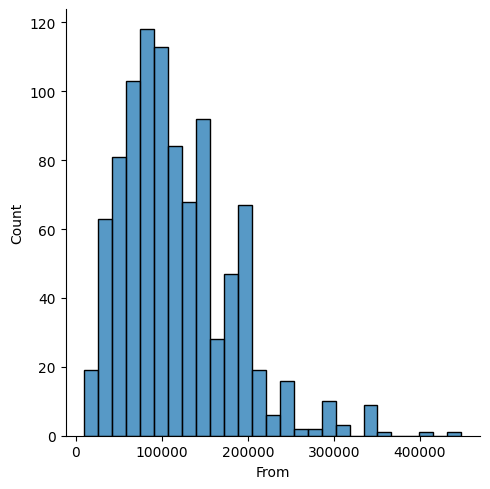

In [44]:
# Оценим распределение нижних границ вилки
sns.displot(kaggle_dataset_1_from['From'])

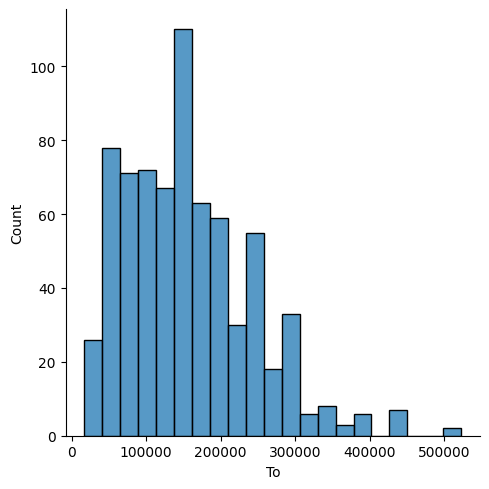

In [45]:
# Оценим распределение верхних границ вилки
sns.displot(kaggle_dataset_1_to['To'])

In [46]:
kaggle_dataset_1[['From', 'Published at']]

,From,Published at
41,50000.0,2021-12-01 16:21:14+03:00
44,130000.0,2021-12-01 16:17:44+03:00
50,80000.0,2021-12-01 16:16:22+03:00
58,50000.0,2021-12-01 16:10:30+03:00
144,120000.0,2021-12-01 15:27:42+03:00
...,...,...
48311,130000.0,2021-10-25 14:42:36+03:00
48439,NaN,2021-10-25 13:15:12+03:00
48440,NaN,2021-10-25 13:15:12+03:00
48547,120000.0,2021-10-25 11:47:19+03:00


## Датасет №2 (ODS Jobs)

### Загрузка данных

Дамп телеграмм канала содержит сообщения со ссылками на [ODS Jobs](https://ods.ai/jobs), нужно скачать эти данные по ссылке. Загрузка данных через http запросы занимает много времени, поэтом сохраним таблицу с объединенными данными после загрузки.

In [47]:
%%script false --no-raise-error
# Ячейка заблокирована, для выполннения удалить строку выше

import json

# Загрузка данных из JSON файла
with open(data_folder / 'ODS jobs.json', 'r', encoding='utf-8') as file:
    ods_jobs_json = json.load(file)

# Извлечение списка сообщений
messages = ods_jobs_json['messages']

# Преобразование в DataFrame
ods_jobs = pd.DataFrame(messages)

# Функция для обработки поля 'text'
def parse_text(text):
    if isinstance(text, list):
        return ''.join([t if isinstance(t, str) else t.get('text', '') for t in text])
    return text

# Применение функции к столбцу 'text'
ods_jobs['text'] = ods_jobs['text'].apply(parse_text)

# Вывод первых нескольких строк DataFrame
ods_jobs.head(10)'''

Couldn't find program: 'false'


In [48]:
%%script false --no-raise-error
# Ячейка заблокирована, для выполннения удалить строку выше

# Функция для скачивания HTML по ссылке
def download_html(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        return f"Error fetching {url}: {e}"

# Функция для извлечения ссылок и скачивания контента
def extract_and_download_html(entities):
    html_contents = []
    for entity in entities:
        if 'href' in entity:
            html_content = download_html(entity['href'])
            html_contents.append(html_content)
    return html_contents

# Применяем функцию для извлечения ссылок и загрузки HTML для каждого элемента в text_entities
ods_jobs['html_content'] = ods_jobs['text_entities'].apply(extract_and_download_html)

# Выводим результат
ods_jobs[['text_entities', 'html_content']]
ods_jobs.to_csv('ODS_jobs.csv', index=False)

Couldn't find program: 'false'


### Подготовка данных

In [49]:
# Считаем сохраненную таблицу, подготовленную на этапе загрузки данных
ods_jobs = pd.read_csv(data_folder / 'ODS_jobs.csv')
ods_jobs.head(5)

,type,date,date_unixtime,actor,actor_id,action,title,text,text_entities,edited,edited_unixtime,from,from_id,reply_to_message_id,message_id,html_content
0,service,2023-03-20T21:46:30,1679337990,ODS #jobs,channel1803785868,create_channel,ODS #jobs,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,[]
1,message,2023-03-21T19:15:48,1679415348,NaN,NaN,NaN,NaN,ETA: 48 часов\nФорма добавления вакансий на od...,"[{'type': 'plain', 'text': 'ETA: 48 часов\nФор...",2023-03-21T22:39:45,1.679428e+09,ODS #jobs,channel1803785868,NaN,NaN,[]
2,message,2023-03-23T18:27:33,1679585253,NaN,NaN,NaN,NaN,/id,"[{'type': 'bot_command', 'text': '/id'}]",2023-03-23T20:41:07,1.679593e+09,ODS #jobs,channel1803785868,NaN,NaN,[]
3,message,2023-03-23T18:27:33,1679585253,NaN,NaN,NaN,NaN,-1001803785868,"[{'type': 'plain', 'text': '-1001803785868'}]",2023-03-23T18:27:39,1.679585e+09,ODS #jobs,channel1803785868,6.0,NaN,[]
4,message,2023-03-23T18:27:48,1679585268,NaN,NaN,NaN,NaN,Сейчас все будет 🤗,"[{'type': 'plain', 'text': 'Сейчас все будет 🤗'}]",2023-03-23T18:27:54,1.679585e+09,ODS #jobs,channel1803785868,NaN,NaN,[]


In [50]:
from bs4 import BeautifulSoup

# Функция для извлечения названия вакансии
def extract_vacancy_title(html_data):
    soup = BeautifulSoup(html_data, 'html.parser')

    # Находим элемент <span> с нужным классом
    vacancy_span = soup.find('span', class_='jsx-fe0e291715a86afa jsx-251439498')
    
    # Извлекаем текст из элемента
    if vacancy_span:
        vacancy_title = vacancy_span.get_text()
        # Убираем слово "Hidden" если оно есть в начале строки
        clean_vacancy_title = vacancy_title.replace("Hidden", "").strip()
        return clean_vacancy_title
    else:
        return None

# Применяем функцию ко всем строкам
ods_jobs['vacancy_title'] = ods_jobs['html_content'].apply(extract_vacancy_title)

# Выводим DataFrame с новым столбцом
ods_jobs


,type,date,date_unixtime,actor,actor_id,action,title,text,text_entities,edited,edited_unixtime,from,from_id,reply_to_message_id,message_id,html_content,vacancy_title
0,service,2023-03-20T21:46:30,1679337990,ODS #jobs,channel1803785868,create_channel,ODS #jobs,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,[],None
1,message,2023-03-21T19:15:48,1679415348,NaN,NaN,NaN,NaN,ETA: 48 часов\nФорма добавления вакансий на od...,"[{'type': 'plain', 'text': 'ETA: 48 часов\nФор...",2023-03-21T22:39:45,1.679428e+09,ODS #jobs,channel1803785868,NaN,NaN,[],None
2,message,2023-03-23T18:27:33,1679585253,NaN,NaN,NaN,NaN,/id,"[{'type': 'bot_command', 'text': '/id'}]",2023-03-23T20:41:07,1.679593e+09,ODS #jobs,channel1803785868,NaN,NaN,[],None
3,message,2023-03-23T18:27:33,1679585253,NaN,NaN,NaN,NaN,-1001803785868,"[{'type': 'plain', 'text': '-1001803785868'}]",2023-03-23T18:27:39,1.679585e+09,ODS #jobs,channel1803785868,6.0,NaN,[],None
4,message,2023-03-23T18:27:48,1679585268,NaN,NaN,NaN,NaN,Сейчас все будет 🤗,"[{'type': 'plain', 'text': 'Сейчас все будет 🤗'}]",2023-03-23T18:27:54,1.679585e+09,ODS #jobs,channel1803785868,NaN,NaN,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,message,2024-08-23T17:18:53,1724422733,NaN,NaN,NaN,NaN,Senior Data scientist (Computer Vision)\n300 0...,"[{'type': 'text_link', 'text': 'Senior Data sc...",2024-08-23T17:19:14,1.724423e+09,ODS #jobs,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Senior Data scientist (Computer Vision)
378,message,2024-08-26T11:33:39,1724661219,NaN,NaN,NaN,NaN,Senior ML Engineer\n3 400 – 4 200 €/месяц\nУда...,"[{'type': 'text_link', 'text': 'Senior ML Engi...",2024-08-26T11:35:04,1.724661e+09,ODS #jobs,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Senior ML Engineer
379,message,2024-08-26T15:20:34,1724674834,NaN,NaN,NaN,NaN,Data Scientist LLM (Global markets)\n250 000 –...,"[{'type': 'text_link', 'text': 'Data Scientist...",2024-08-26T15:22:14,1.724675e+09,ODS #jobs,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Data Scientist LLM (Global markets)
380,message,2024-08-28T11:18:57,1724833137,NaN,NaN,NaN,NaN,Deep Learning Engineer in Audio (Diffusions)\n...,"[{'type': 'text_link', 'text': 'Deep Learning ...",2024-08-28T11:19:23,1.724833e+09,ODS #jobs,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Deep Learning Engineer in Audio (Diffusions)


In [51]:
# Функция для извлечения зарплаты
def extract_salary(html_data):
    soup = BeautifulSoup(html_data, 'html.parser')

    # Находим элементы <strong>
    salary_element = soup.find('strong', class_='jsx-9fa5834268eb3de')
    if salary_element:
        salary_text = salary_element.get_text()
        # Декодируем HTML-сущности
        salary_text = html.unescape(salary_text)
        # Нормализуем текст
        salary_text = unicodedata.normalize('NFKD', salary_text)

        # Удаляем неразрывные пробелы обрезая строки
        # str.replace не срабатывает на экранированных символах
        index = salary_text.find('\\xa0')
        while index != -1:
            salary_text = salary_text[:index] + ' ' + salary_text[index + 4:]
            index = salary_text.find('\\xa0')  # Продолжаем искать и удалять

        return salary_text
    else:
        return None

# Применяем функцию ко всем строкам
ods_jobs['salary_text'] = ods_jobs['html_content'].apply(extract_salary)

In [52]:
# Курсы валют
usd_to_rub = 92.95
eur_to_rub = 103.58

def extract_from_to(price):
    if price is None:
        return pd.Series([None, None])
    
    # Поиск диапазона
    range_match = re.search(r'(\d+[\d,]*)[–-](\d+[\d,]*)', price)
    if range_match:
        low = range_match.group(1).replace(',', '')
        high = range_match.group(2).replace(',', '')
    else:
        # Поиск значения "from"
        from_match = re.search(r'from\s*(\d+[\d,]*)', price)
        if from_match:
            low = from_match.group(1).replace(',', '')
            high = None
        else:
            return pd.Series([None, None])

    # Определение валюты
    if 'USD' in price or '$' in price:
        low = int(low) * usd_to_rub
        if high:
            high = int(high) * usd_to_rub
    elif 'EUR' in price or '€' in price:
        low = int(low) * eur_to_rub
        if high:
            high = int(high) * eur_to_rub
    else:
        low = int(low)
        if high:
            high = int(high)

    return pd.Series([low, high])

# Применяем функцию к колонке
ods_jobs[['from', 'to']] = ods_jobs['salary_text'].apply(extract_from_to)

In [53]:
# Функция для извлечения описания вакансии
def extract_job_description(html_data):
    soup = BeautifulSoup(html_data, 'html.parser')

    # Находим все элементы <div> с классом "ck-content"
    description_divs = soup.find_all('div', class_='ck-content')

    # Если элементы найдены, собираем их текст
    if description_divs:
        job_description = ' '.join([div.get_text(separator=' ').strip() for div in description_divs])
        return job_description
    else:
        return None

# Применяем функцию ко всем строкам
ods_jobs['job_description'] = ods_jobs['html_content'].apply(extract_job_description)

In [54]:
# Удаляем из текста плашку о помещении в архив
ods_jobs['job_description'] = ods_jobs['job_description'].str.replace('Moderation Review In the archive', '', regex=True)

In [55]:
# Отфильтруем вакансии со слишком низкими значением оплаты
# Большинство из них - это почасовые ставки при проектной занятости
ods_jobs = ods_jobs[(ods_jobs['from'] > 10e3) & (ods_jobs['to'] > 10e3)]

In [56]:
# Выведем результат предобработки
ods_jobs.loc[10:15]

,type,date,date_unixtime,actor,actor_id,action,title,text,text_entities,edited,edited_unixtime,from,from_id,reply_to_message_id,message_id,html_content,vacancy_title,salary_text,to,job_description
12,message,2023-04-20T10:09:56,1681974596,NaN,NaN,NaN,NaN,Дата аналитик (data scientist) \nRUB 1400000 –...,"[{'type': 'text_link', 'text': 'Дата аналитик ...",2023-04-20T10:10:21,1.681975e+09,1400000.0,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Дата аналитик (data scientist),"RUB 1,400,000–5,000,000",5000000.0,Ищем в Machine Learning команду специалистов ...
13,message,2023-04-24T10:03:02,1682319782,NaN,NaN,NaN,NaN,Лидер центра компетенций Искусственного Интелл...,"[{'type': 'text_link', 'text': 'Лидер центра к...",NaN,NaN,250000.0,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Лидер центра компетенций Искусственного Интелл...,"RUB 250,000–399,998",399998.0,Группа компаний Московская Биржа ищет лидера ...
14,message,2023-04-24T10:03:49,1682319829,NaN,NaN,NaN,NaN,Machine Learning Engineer\nUSD 3000 – 10000/Mo...,"[{'type': 'text_link', 'text': 'Machine Learni...",NaN,NaN,278850.0,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Machine Learning Engineer,"$3,000–10,000",929500.0,"AI Clone - передовые технологии, которые помо..."
15,message,2023-04-24T10:04:21,1682319861,NaN,NaN,NaN,NaN,Python Developer\nUSD 2000 – 2500/Month\nRemot...,"[{'type': 'text_link', 'text': 'Python Develop...",2023-04-24T10:35:12,1.682322e+09,185900.0,channel1803785868,NaN,NaN,"['<!DOCTYPE html><html lang=""en-US""><head><met...",Python Developer,"$2,000–2,500",232375.0,"Всем привет! В небольшой, но амбициозный межд..."


In [57]:
# Сформируем два датасета. Один с нижней границей зарплатной вилки, второй с верхней границей.
# Отфильтруем выбросы с вилкой выше 1 000 000 руб.
ods_jobs_from = ods_jobs[['vacancy_title', 'from', 'job_description']][(~ods_jobs['from'].isna())&(ods_jobs['from'] <1e6)].reset_index(drop=True)
ods_jobs_to = ods_jobs[['vacancy_title', 'to', 'job_description']][(~ods_jobs['to'].isna())&(ods_jobs['to'] <1e6)].reset_index(drop=True)

# Удалим все строки, в которых есть пропущенные данные
ods_jobs_from = ods_jobs_from.dropna().reset_index(drop=True)
ods_jobs_to = ods_jobs_to.dropna().reset_index(drop=True)

In [58]:
print(ods_jobs_from.shape)
print(ods_jobs_to.shape)

(231, 3)
(227, 3)


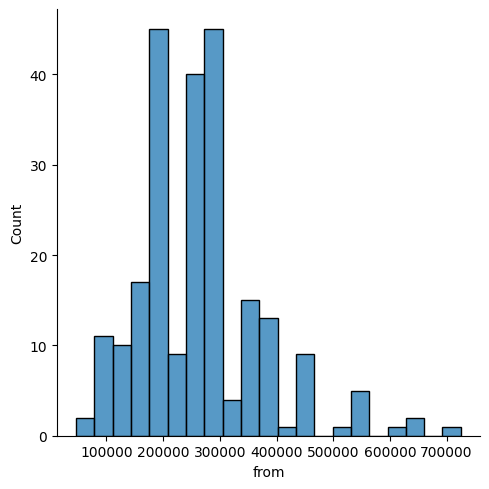

In [59]:
# Оценим распределение нижних границ вилки
sns.displot(ods_jobs_from['from'])

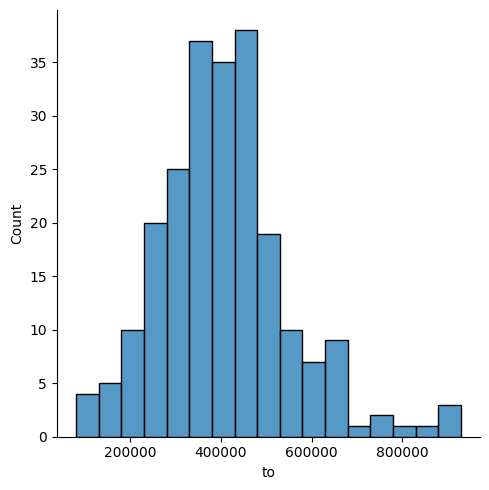

In [60]:
# Оценим распределение верхних границ вилки
sns.displot(ods_jobs_to['to'])

## Объединение данных

In [61]:
# Переименуем столбцы для объединения DataFrame
ods_jobs_from = ods_jobs_from.rename(columns={
    'vacancy_title': 'Name',
    'from': 'From',
    'job_description': 'Description'
})
ods_jobs_to = ods_jobs_to.rename(columns={
    'vacancy_title': 'Name',
    'to': 'To',
    'job_description': 'Description'
})

# Объединим DataFrame
combined_df_from = pd.concat([kaggle_dataset_1_from, ods_jobs_from], ignore_index=True)
combined_df_to = pd.concat([kaggle_dataset_1_to, ods_jobs_to], ignore_index=True)

In [62]:
# Итоговые объединенные DataFrame
display(combined_df_from.head(5))
display(combined_df_to.head(5))

,Name,From,Description
0,Аналитик бизнес-процессов,50000.0,Мы набираем свою команду для разработки и сопр...
1,Руководитель отдела обработки данных,130000.0,Мы расширяем команду Ипотечного брокера и ищем...
2,Аналитик данных,80000.0,Команда Важной Рыбы сейчас активно растет и ищ...
3,Аналитик,50000.0,"Привет, это международная студия образовательн..."
4,Data Scientist (Remote),120000.0,Spark Equation is a software-enabled IT and st...


,Name,To,Description
0,Аналитик данных,120000.0,Команда Важной Рыбы сейчас активно растет и ищ...
1,Аналитик,70000.0,"Привет, это международная студия образовательн..."
2,Data Scientist (Remote),190000.0,Spark Equation is a software-enabled IT and st...
3,BI Developer,230000.0,Мы IT X 100 – мульти продуктовый стартап. Слаж...
4,Аналитик бизнес-процессов,78300.0,Heads and Hands — первая в России студия разра...


In [63]:
print(combined_df_from.shape)
print(combined_df_to.shape)

(1184, 3)
(941, 3)


In [64]:
# Сохранение итоговых наборов данных
combined_df_from.to_csv('combined_df_from', index=False)
combined_df_to.to_csv('combined_df_to', index=False)

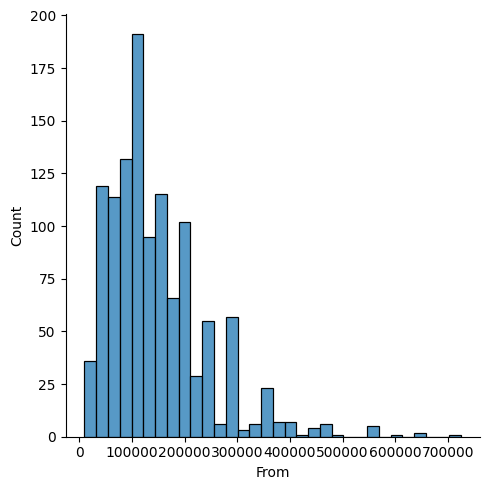

In [65]:
# Оценим распределение нижних границ вилки
sns.displot(combined_df_from['From'])

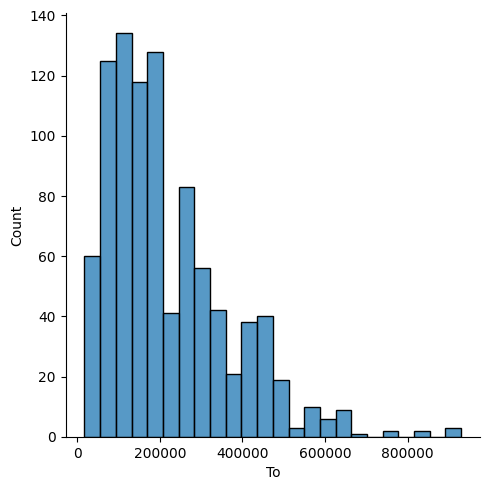

In [66]:
# Оценим распределение нижних границ вилки
sns.displot(combined_df_to['To'])

# Model

In [67]:
# Сохранение итоговых наборов данных
import pandas as pd

combined_df_from = pd.read_csv('combined_df_from')
combined_df_to = pd.read_csv('combined_df_to')

In [68]:
# DataFrame для сохранения результатов
results = pd.DataFrame(columns=['Dataset', 'Method', 'RMSE', 'WMAPE'])

### 1.1 Верхняя граница вилки (TF-IDF -> linear regression (ElasticNet) c подбором параметров)

In [69]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

y = combined_df_to['To']
X = combined_df_to[['Name', 'Description']]

# Преобразование для текстовых полей с использованием TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(), 'Name'),
        ('desc_tfidf', TfidfVectorizer(), 'Description'),
    ])

# Создаем пайплайн с ElasticNet вместо Ridge
pipeline = Pipeline([
    ('tfidf', preprocessor),
    ('regressor', ElasticNet())
])

# Определим сетку параметров, добавив параметры для ElasticNet
param_grid = {
    'tfidf__name_tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__name_tfidf__max_df': [0.5, 0.6, 0.7],
    'tfidf__name_tfidf__min_df': [1, 2],
    'tfidf__desc_tfidf__ngram_range': [(1, 3), (2, 4)],
    'tfidf__desc_tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__desc_tfidf__min_df': [1, 2, 3],
    'regressor__alpha': [0.01, 0.05],
    'regressor__l1_ratio': [0.5, 0.9]
}

# Разделение данных и настройка GridSearchCV остается без изменений
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)

# Предсказания и вычисления также остаются без изменений
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Функция для вычисления WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

wmape_train = wmape(y_train, y_train_pred)
wmape_test = wmape(y_test, y_test_pred)

name_feature_names = best_model.named_steps['tfidf'].transformers_[0][1].get_feature_names_out()
desc_feature_names = best_model.named_steps['tfidf'].transformers_[1][1].get_feature_names_out()

regressor_coef = best_model.named_steps['regressor'].coef_

name_coef = regressor_coef[:len(name_feature_names)]
desc_coef = regressor_coef[len(name_feature_names):]

name_importance = pd.DataFrame({'feature': name_feature_names, 'importance': name_coef})
desc_importance = pd.DataFrame({'feature': desc_feature_names, 'importance': desc_coef})

result = {'Dataset': 'To',
          'Method': 'TF-IDF + ElasticNet (GridSearch)', 
          'RMSE': rmse_test,
          'WMAPE': wmape_test}
results.loc[len(results)] = result

print(f"RMSE на тренировочной выборке: {rmse_train}")
print(f"RMSE на тестовой выборке: {rmse_test}")
print(f"WMAPE на тренировочной выборке: {wmape_train}")
print(f"WMAPE на тестовой выборке: {wmape_test}")

feature_importance = pd.concat([name_importance, desc_importance], ignore_index=True)
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
display(name_importance.sort_values(by='importance', ascending=False), desc_importance.sort_values(by='importance', ascending=False))

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Лучшие параметры: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9, 'tfidf__desc_tfidf__max_df': 0.9, 'tfidf__desc_tfidf__min_df': 3, 'tfidf__desc_tfidf__ngram_range': (1, 3), 'tfidf__name_tfidf__max_df': 0.6, 'tfidf__name_tfidf__min_df': 1, 'tfidf__name_tfidf__ngram_range': (1, 1)}
Лучший результат (MSE): 7504610892.870179
RMSE на тренировочной выборке: 34112.16210008935
RMSE на тестовой выборке: 76943.55064622361
WMAPE на тренировочной выборке: 10.417291477226222
WMAPE на тестовой выборке: 25.277714805339212


,feature,importance
148,senior,194549.467290
83,java,158770.432272
105,mlops,148993.477565
305,команду,148411.387871
136,replika,132491.751252
...,...,...
480,специалист,-74998.092044
341,младший,-87402.748420
84,junior,-97551.340429
482,стажер,-102076.694133


,feature,importance
549,and,162867.675143
1561,in,104377.751256
4939,видео,102288.998801
3047,to,87930.628587
466,ai,87905.377809
...,...,...
13894,обязанности,-52171.650441
1240,excel,-54387.029369
7617,желание,-56877.394290
2487,quot,-61082.160948


In [70]:
import joblib

# Извлечение лучших параметров
best_params = grid_search.best_params_

# Обновляем пайплайн с лучшими параметрами
pipeline.set_params(**best_params)

# Обучаем модель на всех данных (X и y)
pipeline.fit(X, y)

# Сохраняем модель на диск
model_filename = 'model_to.pkl'
joblib.dump(pipeline, model_filename)

print(f"Модель сохранена")

Модель сохранена


In [71]:
feature_importance.to_csv('feature_importance_to.csv', index=False)

### 1.2 Нижняя граница вилки (TF-IDF -> linear regression (ElasticNet) c подбором параметров)

In [72]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

y = combined_df_from['From']
X = combined_df_from[['Name', 'Description']]

# Преобразование для текстовых полей с использованием TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(), 'Name'),
        ('desc_tfidf', TfidfVectorizer(), 'Description'),
    ])

# Создаем пайплайн с ElasticNet вместо Ridge
pipeline = Pipeline([
    ('tfidf', preprocessor),
    ('regressor', ElasticNet())
])

# Определим сетку параметров, добавив параметры для ElasticNet
param_grid = {
    'tfidf__name_tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__name_tfidf__max_df': [0.5, 0.6, 0.7],
    'tfidf__name_tfidf__min_df': [1, 2],
    'tfidf__desc_tfidf__ngram_range': [(1, 3), (2, 4)],
    'tfidf__desc_tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__desc_tfidf__min_df': [1, 2, 3],
    'regressor__alpha': [0.01, 0.05],
    'regressor__l1_ratio': [0.5, 0.9]
}

# Разделение данных и настройка GridSearchCV остается без изменений
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)

# Предсказания и вычисления также остаются без изменений
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))


# Функция для вычисления WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

wmape_train = wmape(y_train, y_train_pred)
wmape_test = wmape(y_test, y_test_pred)

name_feature_names = best_model.named_steps['tfidf'].transformers_[0][1].get_feature_names_out()
desc_feature_names = best_model.named_steps['tfidf'].transformers_[1][1].get_feature_names_out()

regressor_coef = best_model.named_steps['regressor'].coef_

name_coef = regressor_coef[:len(name_feature_names)]
desc_coef = regressor_coef[len(name_feature_names):]

name_importance = pd.DataFrame({'feature': name_feature_names, 'importance': name_coef})
desc_importance = pd.DataFrame({'feature': desc_feature_names, 'importance': desc_coef})

result = {'Dataset': 'From',
          'Method': 'TF-IDF + ElasticNet (GridSearch)', 
          'RMSE': rmse_test,
          'WMAPE': wmape_test}
results.loc[len(results)] = result

print(f"RMSE на тренировочной выборке: {rmse_train}")
print(f"RMSE на тестовой выборке: {rmse_test}")
print(f"WMAPE на тренировочной выборке: {wmape_train}")
print(f"WMAPE на тестовой выборке: {wmape_test}")

feature_importance = pd.concat([name_importance, desc_importance], ignore_index=True)
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
display(name_importance.sort_values(by='importance', ascending=False), desc_importance.sort_values(by='importance', ascending=False))

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Лучшие параметры: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9, 'tfidf__desc_tfidf__max_df': 0.9, 'tfidf__desc_tfidf__min_df': 3, 'tfidf__desc_tfidf__ngram_range': (1, 3), 'tfidf__name_tfidf__max_df': 0.6, 'tfidf__name_tfidf__min_df': 2, 'tfidf__name_tfidf__ngram_range': (1, 1)}
Лучший результат (MSE): 3707815596.686655
RMSE на тренировочной выборке: 29156.823272979018
RMSE на тестовой выборке: 59418.7660391671
WMAPE на тренировочной выборке: 13.73297343680386
WMAPE на тестовой выборке: 26.9515224832032


,feature,importance
52,mlops,175640.087216
72,senior,119184.870580
63,recsys,102816.638128
22,deep,95479.721719
40,java,93992.774302
...,...,...
178,оператор,-46519.290656
229,стажер,-58464.784357
226,специалист,-58470.169847
163,младший,-69086.616893


,feature,importance
651,and,81868.210640
1775,in,79589.361000
1523,for,71045.004167
16195,опыт,58629.358000
580,ai,52120.199550
...,...,...
1413,excel,-38872.901064
25863,требования,-39386.615528
26626,условия,-42308.250339
2813,quot,-45863.268400


In [73]:
import joblib

# Извлечение лучших параметров
best_params = grid_search.best_params_

# Обновляем пайплайн с лучшими параметрами
pipeline.set_params(**best_params)

# Обучаем модель на всех данных (X и y)
pipeline.fit(X, y)

# Сохраняем модель на диск
model_filename = 'model_from.pkl'
joblib.dump(pipeline, model_filename)

print(f"Модель сохранена")

Модель сохранена


In [74]:
feature_importance.to_csv('feature_importance_from.csv', index=False)

### 2.1 Нижняя граница вилки (TF-IDF -> linear regression c подбором параметров)

In [75]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

y = combined_df_from['From']
X = combined_df_from[['Name', 'Description']]

# Преобразование для текстовых полей с использованием TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(1,2)), 'Name'),
        ('desc_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(3,5)), 'Description'),
    ])

# Создаем пайплайн
pipeline = Pipeline([
    ('tfidf', preprocessor),
    ('regressor', LinearRegression())
])

# Определим сетку параметров
param_grid = {
    'tfidf__name_tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__name_tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__name_tfidf__min_df': [1, 2],
    'tfidf__desc_tfidf__ngram_range': [(1, 2), (3, 5)],
    'tfidf__desc_tfidf__max_df': [0.7, 0.8],
    'tfidf__desc_tfidf__min_df': [1, 2],
    'regressor__fit_intercept': [True, False],
}

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучаем GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)

# Получение лучшей модели из GridSearchCV
best_model = grid_search.best_estimator_

# Предсказания на тестовых данных с лучшей моделью
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Вычисление RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Функция для вычисления WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Вычисление WMAPE на тренировочной и тестовой выборках
wmape_train = wmape(y_train, y_train_pred)
wmape_test = wmape(y_test, y_test_pred)

# Важность фичей
# Достаем списки слов-фичей из TF-IDF для Name и Description
name_feature_names = best_model.named_steps['tfidf'].transformers_[0][1].get_feature_names_out()
desc_feature_names = best_model.named_steps['tfidf'].transformers_[1][1].get_feature_names_out()

# Получаем коэффициенты регрессии
regressor_coef = best_model.named_steps['regressor'].coef_

# Коэффициенты для Name фичей
name_coef = regressor_coef[:len(name_feature_names)]
# Коэффициенты для Description фичей
desc_coef = regressor_coef[len(name_feature_names):]

# Создаем DataFrame для удобного отображения важности фичей
name_importance = pd.DataFrame({'feature': name_feature_names, 'importance': name_coef})
desc_importance = pd.DataFrame({'feature': desc_feature_names, 'importance': desc_coef})

# Запишем результаты в DataFrame
result = {'Dataset': 'From',
          'Method': 'TF-IDF + LinReg (GridSearch)', 
          'RMSE': rmse_test,
          'WMAPE': wmape_test}
results.loc[len(results)] = result

# Вывод результатов
print(f"RMSE на тренировочной выборке: {rmse_train}")
print(f"RMSE на тестовой выборке: {rmse_test}")
print(f"WMAPE на тренировочной выборке: {wmape_train}")
print(f"WMAPE на тестовой выборке: {wmape_test}")

# Объединяем и выводим важность
feature_importance = pd.concat([name_importance, desc_importance], ignore_index=True)
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
display(name_importance.sort_values(by='importance', ascending=False), desc_importance.sort_values(by='importance', ascending=False))


Лучшие параметры: {'regressor__fit_intercept': True, 'tfidf__desc_tfidf__max_df': 0.7, 'tfidf__desc_tfidf__min_df': 1, 'tfidf__desc_tfidf__ngram_range': (1, 2), 'tfidf__name_tfidf__max_df': 0.7, 'tfidf__name_tfidf__min_df': 2, 'tfidf__name_tfidf__ngram_range': (1, 1)}
Лучший результат (MSE): 3587945532.531569
RMSE на тренировочной выборке: 1624.7816958314336
RMSE на тестовой выборке: 57342.28272066499
WMAPE на тренировочной выборке: 0.0725515363352125
WMAPE на тестовой выборке: 26.034852843045854


,feature,importance
52,mlops,209556.381430
40,java,150472.420891
63,recsys,133977.051528
72,senior,121258.576770
66,researcher,119081.245157
...,...,...
178,оператор,-59782.207361
226,специалист,-66515.733486
229,стажер,-77362.965788
41,junior,-78238.833185


,feature,importance
2650,and,117843.106211
43859,желательные образование,108559.349321
1392,34 опыт,101694.083481
8240,for,95397.068252
109063,рф заработная,91674.287748
...,...,...
123222,товаров,-63999.009482
15081,procys,-65100.906789
1391,34 образование,-109044.005136
123031,тк заработная,-109044.005136


### 2.2 Верхняя граница вилки (TF-IDF -> linear regression c подбором параметров)

In [76]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

y = combined_df_to['To']
X = combined_df_to[['Name', 'Description']]

# Преобразование для текстовых полей с использованием TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(1,2)), 'Name'),
        ('desc_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(3,5)), 'Description'),
    ])

# Создаем пайплайн
pipeline = Pipeline([
    ('tfidf', preprocessor),
    ('regressor', LinearRegression())
])

# Определим сетку параметров
param_grid = {
    'tfidf__name_tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__name_tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__name_tfidf__min_df': [1, 2],
    'tfidf__desc_tfidf__ngram_range': [(1, 2), (3, 5)],
    'tfidf__desc_tfidf__max_df': [0.7, 0.8],
    'tfidf__desc_tfidf__min_df': [1, 2],
    'regressor__fit_intercept': [True, False],
}

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучаем GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)

# Получение лучшей модели из GridSearchCV
best_model = grid_search.best_estimator_

# Предсказания на тестовых данных с лучшей моделью
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Вычисление RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Функция для вычисления WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Вычисление WMAPE на тренировочной и тестовой выборках
wmape_train = wmape(y_train, y_train_pred)
wmape_test = wmape(y_test, y_test_pred)

# Важность фичей
# Достаем списки слов-фичей из TF-IDF для Name и Description
name_feature_names = best_model.named_steps['tfidf'].transformers_[0][1].get_feature_names_out()
desc_feature_names = best_model.named_steps['tfidf'].transformers_[1][1].get_feature_names_out()

# Получаем коэффициенты регрессии
regressor_coef = best_model.named_steps['regressor'].coef_

# Коэффициенты для Name фичей
name_coef = regressor_coef[:len(name_feature_names)]
# Коэффициенты для Description фичей
desc_coef = regressor_coef[len(name_feature_names):]

# Создаем DataFrame для удобного отображения важности фичей
name_importance = pd.DataFrame({'feature': name_feature_names, 'importance': name_coef})
desc_importance = pd.DataFrame({'feature': desc_feature_names, 'importance': desc_coef})

# Запишем результаты в DataFrame
result = {'Dataset': 'To',
          'Method': 'TF-IDF + LinReg (GridSearch)', 
          'RMSE': rmse_test,
          'WMAPE': wmape_test}
results.loc[len(results)] = result

# Вывод результатов
print(f"RMSE на тренировочной выборке: {rmse_train}")
print(f"RMSE на тестовой выборке: {rmse_test}")
print(f"WMAPE на тренировочной выборке: {wmape_train}")
print(f"WMAPE на тестовой выборке: {wmape_test}")

# Объединяем и выводим важность
feature_importance = pd.concat([name_importance, desc_importance], ignore_index=True)
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
display(name_importance.sort_values(by='importance', ascending=False), desc_importance.sort_values(by='importance', ascending=False))


Лучшие параметры: {'regressor__fit_intercept': True, 'tfidf__desc_tfidf__max_df': 0.8, 'tfidf__desc_tfidf__min_df': 1, 'tfidf__desc_tfidf__ngram_range': (1, 2), 'tfidf__name_tfidf__max_df': 0.7, 'tfidf__name_tfidf__min_df': 2, 'tfidf__name_tfidf__ngram_range': (1, 1)}
Лучший результат (MSE): 7544255084.915088
RMSE на тренировочной выборке: 3.937794686125718
RMSE на тестовой выборке: 76072.84238220833
WMAPE на тренировочной выборке: 0.0007733725146780073
WMAPE на тестовой выборке: 24.06150284149661


,feature,importance
3,ai,188960.623323
43,mlops,188203.200511
64,senior,184692.671217
60,researcher,183805.280655
32,java,182781.052523
...,...,...
114,инженер,-89184.478735
136,оператор,-90795.663366
183,специалист,-97000.252216
130,младший,-115425.928646


,feature,importance
2409,and,213069.396397
7868,fraud,162643.649495
9134,in,142481.595196
7869,fraud detection,133877.290966
7724,for,115870.999373
...,...,...
19283,will,-71075.795752
17796,the,-71245.577775
5949,development,-74271.298092
14776,quot,-81144.939746


### 3.1 Нижняя граница вилки (TF-IDF -> xgboost)

In [77]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

y = combined_df_from['From']
X = combined_df_from[['Name', 'Description']]

# Преобразование для текстовых полей с использованием TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(1, 2)), 'Name'),
        ('desc_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(3, 5)), 'Description'),
    ])

# Создаем пайплайн с XGBRegressor
pipeline = Pipeline([
    ('tfidf', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем пайплайн
pipeline.fit(X_train, y_train)

# Предсказания на тестовых данных
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Вычисление RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Функция для вычисления WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Вычисление WMAPE на тренировочной и тестовой выборках
wmape_train = wmape(y_train, y_train_pred)
wmape_test = wmape(y_test, y_test_pred)

# Получаем имена фичей из ColumnTransformer
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            continue
        elif hasattr(transformer, 'get_feature_names_out'):
            transformer_feature_names = transformer.get_feature_names_out()
            # Добавляем имя преобразователя к имени признака для уникальности
            transformer_feature_names = [f"{name}__{feat}" for feat in transformer_feature_names]
            feature_names.extend(transformer_feature_names)
        else:
            # Обработка преобразователей без метода get_feature_names_out
            n_features = transformer.transform(np.empty((0, len(columns)))).shape[1]
            transformer_feature_names = [f"{name}__{i}" for i in range(n_features)]
            feature_names.extend(transformer_feature_names)
    return feature_names

# Получаем все имена признаков из препроцессора
feature_names = get_feature_names_from_column_transformer(pipeline.named_steps['tfidf'])

# Получаем важность признаков из регрессора
feature_importances = pipeline.named_steps['regressor'].feature_importances_

# Проверяем соответствие размеров
assert len(feature_names) == len(feature_importances), "Количество признаков и важностей не совпадает!"

# Создаем DataFrame для удобного отображения важности признаков
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Сортируем по важности
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Запишем результаты в DataFrame
result = {'Dataset': 'From',
          'Method': 'TF-IDF + XGBoost', 
          'RMSE': rmse_test,
          'WMAPE': wmape_test}
results.loc[len(results)] = result

# Вывод результатов
print(f"RMSE на тренировочной выборке: {rmse_train}")
print(f"RMSE на тестовой выборке: {rmse_test}")
print(f"WMAPE на тренировочной выборке: {wmape_train}")
print(f"WMAPE на тестовой выборке: {wmape_test}")

# Выводим важность признаков
display(feature_importance_df)

RMSE на тренировочной выборке: 26377.77317461117
RMSE на тестовой выборке: 66226.06155827396
WMAPE на тренировочной выборке: 14.720034478872233
WMAPE на тестовой выборке: 30.677661567395692


,feature,importance
558,name_tfidf__senior,0.027779
3847,desc_tfidf__10s of microseconds,0.024820
24285,desc_tfidf__degree in computer,0.014892
70496,desc_tfidf__with the ability,0.013876
415,name_tfidf__ml разработчик,0.012774
...,...,...
164221,desc_tfidf__заказывает еду на,0.000000
164220,desc_tfidf__заказы тендеры планирование продаж...,0.000000
164219,desc_tfidf__заказы тендеры планирование продаж,0.000000
164218,desc_tfidf__заказы тендеры планирование,0.000000


### 3.2 Верхняя граница вилки (TF-IDF -> xgboost)

In [78]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

y = combined_df_to['To']
X = combined_df_to[['Name', 'Description']]

# Преобразование для текстовых полей с использованием TF-IDF
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(1, 2)), 'Name'),
        ('desc_tfidf', TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(3, 5)), 'Description'),
    ])

# Создаем пайплайн с XGBRegressor
pipeline = Pipeline([
    ('tfidf', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем пайплайн
pipeline.fit(X_train, y_train)

# Предсказания на тестовых данных
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Вычисление RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Функция для вычисления WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Вычисление WMAPE на тренировочной и тестовой выборках
wmape_train = wmape(y_train, y_train_pred)
wmape_test = wmape(y_test, y_test_pred)

# Получаем имена фичей из ColumnTransformer
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            continue
        elif hasattr(transformer, 'get_feature_names_out'):
            transformer_feature_names = transformer.get_feature_names_out()
            # Добавляем имя преобразователя к имени признака для уникальности
            transformer_feature_names = [f"{name}__{feat}" for feat in transformer_feature_names]
            feature_names.extend(transformer_feature_names)
        else:
            # Обработка преобразователей без метода get_feature_names_out
            n_features = transformer.transform(np.empty((0, len(columns)))).shape[1]
            transformer_feature_names = [f"{name}__{i}" for i in range(n_features)]
            feature_names.extend(transformer_feature_names)
    return feature_names

# Получаем все имена признаков из препроцессора
feature_names = get_feature_names_from_column_transformer(pipeline.named_steps['tfidf'])

# Получаем важность признаков из регрессора
feature_importances = pipeline.named_steps['regressor'].feature_importances_

# Проверяем соответствие размеров
assert len(feature_names) == len(feature_importances), "Количество признаков и важностей не совпадает!"

# Создаем DataFrame для удобного отображения важности признаков
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Сортируем по важности
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Запишем результаты в DataFrame
result = {'Dataset': 'To',
          'Method': 'TF-IDF + XGBoost', 
          'RMSE': rmse_test,
          'WMAPE': wmape_test}
results.loc[len(results)] = result

# Вывод результатов
print(f"RMSE на тренировочной выборке: {rmse_train}")
print(f"RMSE на тестовой выборке: {rmse_test}")
print(f"WMAPE на тренировочной выборке: {wmape_train}")
print(f"WMAPE на тестовой выборке: {wmape_test}")

# Выводим важность признаков
display(feature_importance_df)

RMSE на тренировочной выборке: 33120.350687690756
RMSE на тестовой выборке: 96211.72542494319
WMAPE на тренировочной выборке: 12.222639965984264
WMAPE на тестовой выборке: 30.47292096653359


,feature,importance
7487,desc_tfidf__40 ая скидка на покупку,0.034983
284,name_tfidf__junior data,0.020410
245860,desc_tfidf__опыт программирования на,0.018388
509,name_tfidf__senior ml,0.016963
367,name_tfidf__mlops,0.014731
...,...,...
138910,desc_tfidf__задач например как реализовать,0.000000
138909,desc_tfidf__задач например как,0.000000
138908,desc_tfidf__задач например apache airflow sql,0.000000
138907,desc_tfidf__задач например apache airflow,0.000000


In [79]:
# Сводная таблица по результатам
results

,Dataset,Method,RMSE,WMAPE
0,To,TF-IDF + ElasticNet (GridSearch),76943.550646,25.277715
1,From,TF-IDF + ElasticNet (GridSearch),59418.766039,26.951522
2,From,TF-IDF + LinReg (GridSearch),57342.282721,26.034853
3,To,TF-IDF + LinReg (GridSearch),76072.842382,24.061503
4,From,TF-IDF + XGBoost,66226.061558,30.677662
5,To,TF-IDF + XGBoost,96211.725425,30.472921


# Выводы:


1) Эксперимент с использованием эмбедингов признан неудачным, качество повысить не удалось. Ноутбук с экспериментами - [ссылка](https://github.com/KorneevRV/MFDP_catch_me_if_you_can/blob/main/notebooks/enhanced_model_embed.ipynb). Возможно следует вернуться к этому подходу в процессе развития проекта.
2) Лучшая полученная модель - TF-IDF + LinReg with ElasticNet. Полученная достигла лучших значений метрик среди всех экспериментов. Кроме этого, он не переобучена, что следует из соотношения метрик на тестовой и тренировочной части выборки (в среднем 1:2.5), остальные модели значительно переобучались (соотношение метрик 1:10 - 1:100).